# Making Estimations with our NBA dataset

Let's explore how to make predictive models for regression and classification tasks using ScikitLearn with our extracted, preprocess and clean NBA data.

#### The goals of this project are:

- Define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

### 1. Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

### Analyzing our data

In [1]:
import pylab 
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [11]:
data = pd.read_csv("project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)

All players statistics ("PTS", "REB", "AST","STL","BLK") against salary

In [3]:
data.head()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"


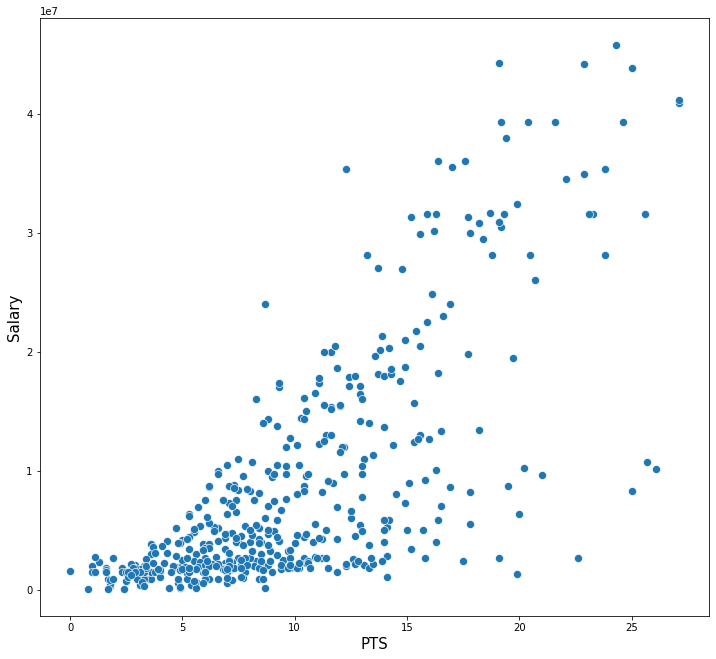

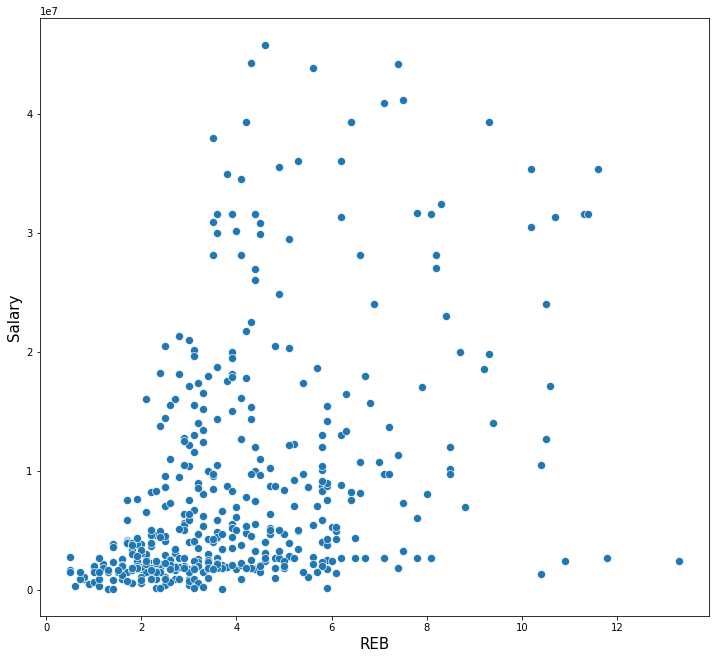

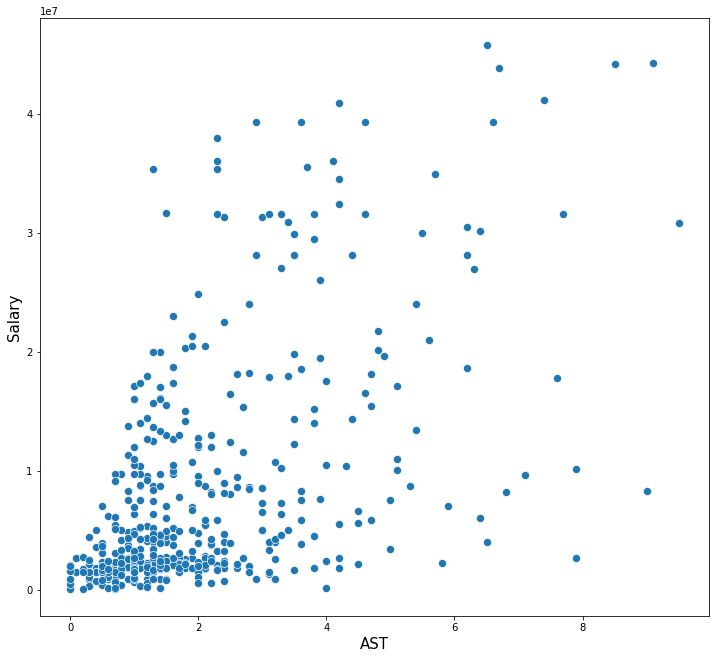

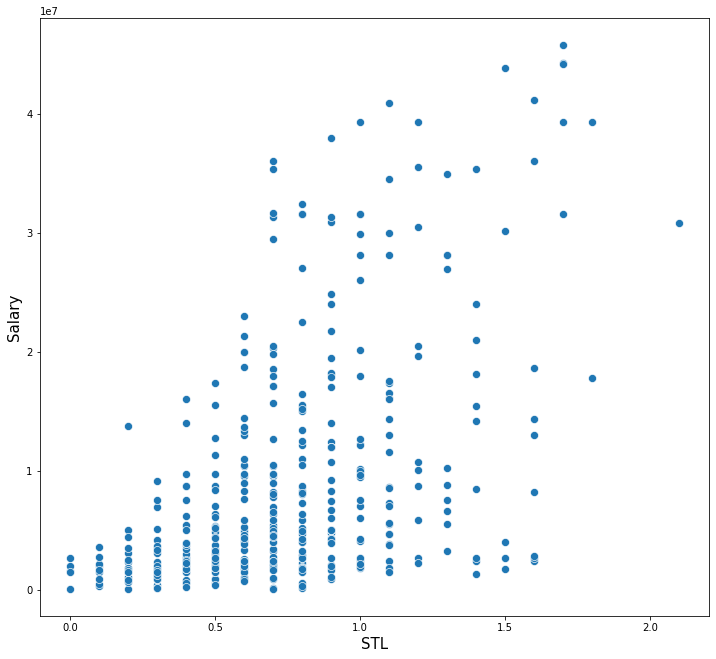

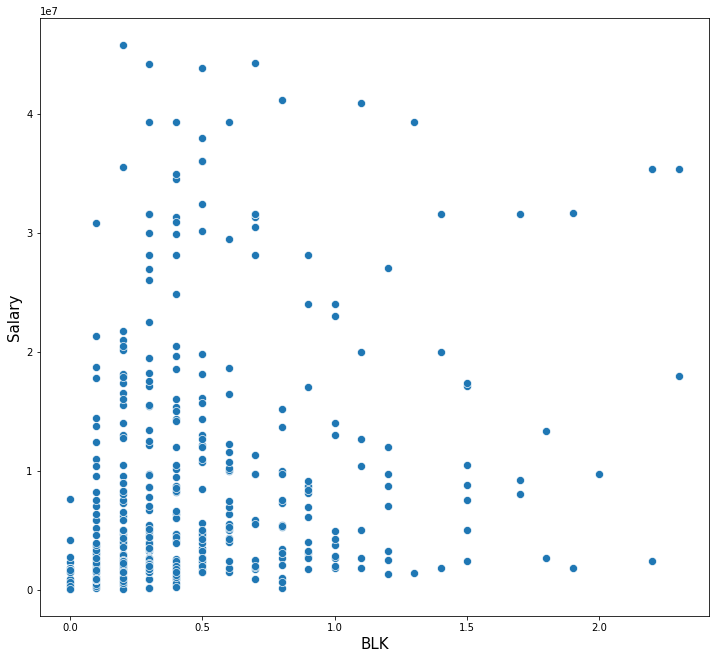

In [4]:
# NOTE: PTS vs Salary
plt.figure(figsize=(12,11))
plt.xlabel('PTS', fontsize= 15)
plt.ylabel('Salary', fontsize= 15)
sns.scatterplot(data=data, x='PTS', y='Salary',s=65,sizes=(30,100), palette='deep')
plt.show()


# NOTE: REB vs Salary
plt.figure(figsize=(12,11))
plt.xlabel('REB', fontsize= 15)
plt.ylabel('Salary', fontsize= 15)
sns.scatterplot(data=data, x='REB', y='Salary',s=65,sizes=(30,100), palette='deep')
plt.show()


# NOTE: AST vs Salary
plt.figure(figsize=(12,11))
plt.xlabel('AST', fontsize= 15)
plt.ylabel('Salary', fontsize= 15)
sns.scatterplot(data=data, x='AST', y='Salary',s=65,sizes=(30,100), palette='deep')
plt.show()

# NOTE: STL vs Salary
plt.figure(figsize=(12,11))
plt.xlabel('STL', fontsize= 15)
plt.ylabel('Salary', fontsize= 15)
sns.scatterplot(data=data, x='STL', y='Salary',s=65,sizes=(30,100), palette='deep')
plt.show()

# NOTE: BLK vs SALARY
plt.figure(figsize=(12,11))
plt.xlabel('BLK', fontsize= 15)
plt.ylabel('Salary', fontsize= 15)
sns.scatterplot(data=data, x='BLK', y='Salary',s=65,sizes=(30,100), palette='deep')
plt.show()

#### What can we say about these distributions?

- Points vs Salary: We see a clear positive correlation between the feature (Points) and the target value (Salary). As a player, the more points you make, greater the salary you'll earn. The points has the strongest correlation against Salary. In this case, the salary explains very well the points per game for every player.
- Reb vs Salary: There is a good correlation until the 6 rebs per game. After 6 rebs, the correlation dilutes. 
- Asist vs Salary: We don't see any correlation worth to study or observe. In the firsts mean values it seems to be a modest correlation (=> 0.5). 
- STLs / BLKs vs Salary: There is no correlation between these variables. Both are independent on the distribution against Salary.

### Splitting the Dataset

Split the dataset into train and testing sets. 

In [6]:
X = data.loc[:, data.columns != 'Salary']

y = data['Salary']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)


### Baseline Model and Evaluation Metric

We need an evaluation metric and a baseline model to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

Baseline model class that implements fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [8]:
class BaselineModel():
  """
  A baseline model that always returns the same value, the mean of the 
  players salary in the train data
  """
  def __init__(self):
    self.trained_data = 0
  
  def fit(self, y_train):
    """
    Fit the training data. 
    
    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """
    self.trained_data = round(y_train.mean())

  
  def predict(self, X):
    """
    Predict salaries 
    
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
        
    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 
        the mean salary calculated in fit()
    """
    X = np.full(len(X),self.trained_data)

    return X

Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [18]:
b_l_m = BaselineModel()

# For this case we are using test set instead of validation set.

b_l_m.fit(y_train)
y_predicted = b_l_m.predict(X_test)

baseline_mae = round(mean_absolute_error(y_test, y_predicted))

In [19]:
print(f'Baseline MAE: {baseline_mae}')

Baseline MAE: 6948493


### Regression with a single variable

In [16]:
scaler = StandardScaler()


X_train[['PTS']] = scaler.fit_transform(X_train[['PTS']])
X_test[['PTS']] = scaler.transform(X_test[['PTS']])

In [20]:
# Create the SGDR object
sgd_regressor = linear_model.SGDRegressor()

# Fit the function to our train datasets

sgd_regressor.fit(X_train[['PTS']],y_train)

# Predict values
y_predicted = sgd_regressor.predict(X_test.PTS.values.reshape(-1,1))

# Calculate the metric to evaluate performance
default_mae = round(mean_absolute_error(y_test, y_predicted),2)
print(default_mae)


4908976.27


c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


In [30]:
def best_simple_regression(max_iter: int, eta0: float) -> dict:
  """
  Function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. 

  For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination. 

  Finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

  Parameters
  ------------------------------
  max_iter: int
  eta0: float
  
  Return
  ------------------------------
  result: dict
  """
  result = {
    "hyperparameters": {"max_iter": None, "eta0": None}, 
    "mae": None
  }
  # Find the best hyperparameters for our model
  mae = math.inf
  for max_iter_1 in max_iter:
    print(f'Trying max_iter: {max_iter_1}')
    for eta0_1 in eta0:
      print(f'With {max_iter_1}, trying eta0: {eta0_1}')
      sgd_regressor = linear_model.SGDRegressor(max_iter=max_iter_1,eta0=eta0_1,random_state=3)
      sgd_regressor.fit(X_train[['PTS']],y_train)
      to_predict = sgd_regressor.predict(X_test[['PTS']])
      mae_sgdr = mean_absolute_error(y_test, to_predict)
      print(f'With max_iter: {max_iter_1} and eta0: {eta0_1}: \nMAE: {round(mae_sgdr,3)}')
      print("")
      if mae_sgdr < mae:
        mae = mae_sgdr
        result = {
        "hyperparameters": {"max_iter": max_iter_1, "eta0": eta0_1}, 
        "mae": round(mae_sgdr,3)
      }
      else:
        break

  return result

In [31]:
# List/Array of hyperparameters to iterate over

max_iter = [10**3, 10**4, 10**5, 10**6, 10**7, 10**8]

eta0 = np.linspace(0.0001,1,num=50)

result = best_simple_regression(max_iter, eta0)
print('Best Hyperparameters for this regression', result)

Trying max_iter: 1000
With 1000, trying eta0: 0.0001
With max_iter: 1000 and eta0: 0.0001: 
MAE: 4774100.224

With 1000, trying eta0: 0.02050612244897959
With max_iter: 1000 and eta0: 0.02050612244897959: 
MAE: 4923158.74

Trying max_iter: 10000
With 10000, trying eta0: 0.0001
With max_iter: 10000 and eta0: 0.0001: 
MAE: 4909944.012

Trying max_iter: 100000
With 100000, trying eta0: 0.0001


c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


With max_iter: 100000 and eta0: 0.0001: 
MAE: 4909944.012

Trying max_iter: 1000000
With 1000000, trying eta0: 0.0001
With max_iter: 1000000 and eta0: 0.0001: 
MAE: 4909944.012

Trying max_iter: 10000000
With 10000000, trying eta0: 0.0001
With max_iter: 10000000 and eta0: 0.0001: 
MAE: 4909944.012

Trying max_iter: 100000000
With 100000000, trying eta0: 0.0001
With max_iter: 100000000 and eta0: 0.0001: 
MAE: 4909944.012

Best Hyperparameters for this regression {'hyperparameters': {'max_iter': 1000, 'eta0': 0.0001}, 'mae': 4774100.224}


In [32]:
# #: Regression with a single variable
best_mae_uni = result['mae']
best_max_iter_uni = result['hyperparameters']['max_iter']
best_eta0_uni = result['hyperparameters']['eta0']

Let's compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters we could find.

- **As we can see, we could decrease the error (the space between predicted and truth values) by tunning the hyperparameters**

In [40]:
print("Mean Absolute Error for each model")
print("")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {round(default_mae,2)}")
print(f"Best SGDRegressor found with best_simple_regression():", best_mae_uni)

Mean Absolute Error for each model

Baseline: 6948493
Default SGDRegressor: 4908976.27
Best SGDRegressor found with best_simple_regression(): 4774100.224


### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
Let's start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number




- ["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [41]:
# Create a copy of our initial DF
mv_regression_df = data.copy()

# PERSON_ID (player_id) as index
mv_regression_df.set_index('PERSON_ID',inplace=True)

# Select the following columns 
columns = ["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "Salary"]

# Pick our dataframe with only those we selected before.
mv_regression_df = mv_regression_df[columns]
mv_regression_df.head(3)

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary
PERSON_ID,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,2711280
203500,9.3,7.9,1.4,0.9,8,Center,12,17073171
1628389,13.2,8.2,3.5,0.9,4,Center,14,28103550


#### Feature Engineering

Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       

In [47]:
# Replace Undrafted with 0
mv_regression_df['DRAFT_NUMBER'].replace('Undrafted',0,inplace=True)

# Fill NaN with 0
mv_regression_df.fillna(0,inplace=True)

# Cast to integer
mv_regression_df.loc[:,'DRAFT_NUMBER'] = mv_regression_df['DRAFT_NUMBER'].astype(int)

# Bins
bins = [0,1,15,30,60]

# List of labels 
labels = ['undrafted','firstround_lottery','firstround_non_lottery','second_round']


mv_regression_df['DRAFT'] = pd.cut(mv_regression_df['DRAFT_NUMBER'], bins=bins, include_lowest=True ,labels=labels)
mv_regression_df.head(3)

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,DRAFT
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,2711280,firstround_non_lottery
203500,9.3,7.9,1.4,0.9,8,Center,12,17073171,firstround_lottery
1628389,13.2,8.2,3.5,0.9,4,Center,14,28103550,firstround_lottery


Encode the categorical features: DRAFT, POSITION

In [49]:
mv_regression_df = pd.get_dummies(data=mv_regression_df,columns=['DRAFT','POSITION'], drop_first=True)

#### Modeling

Split the dataset into train and test. 

In [59]:
X = mv_regression_df.loc[:, (mv_regression_df.columns != 'Salary') & (mv_regression_df.columns != 'DRAFT_NUMBER')]

y = mv_regression_df['Salary']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=42)

Feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number.

In [61]:
scaler = StandardScaler()

# Scale data (fit & transform) in X_train dataset

X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = scaler.fit_transform(X_train[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])

# Idem with X_test

X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = scaler.transform(X_test[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]])


In [62]:
def best_mv_regression(max_iter, eta0):
  result_mv = {
    "hyperparameters": {"max_iter": None, "eta0": None}, 
    "mae": None
  }
  mae = math.inf
  for max_iter_1 in max_iter:
    print(f'Trying max_iter: {max_iter_1}')
    for eta0_1 in eta0:
      print(f'With {max_iter_1}, trying eta0: {eta0_1}')
      sgd_regressor = linear_model.SGDRegressor(max_iter=max_iter_1,eta0=eta0_1,random_state=7)
      sgd_regressor.fit(X_train,y_train)
      y_predicted = sgd_regressor.predict(X_test)
      mae_sgdr = mean_absolute_error(y_test, y_predicted)
      print(f'With max_iter: {max_iter_1} and eta0: {eta0_1}: \nMAE: {round(mae_sgdr,3)}')
      print("")
      if mae_sgdr < mae:
        mae = mae_sgdr
        result_mv = {
        "hyperparameters": {"max_iter": max_iter_1, "eta0": eta0_1}, 
        "mae": round(mae_sgdr,2)
      }

  return result_mv

In [63]:
# Set space/values for hyperparameters to iterate

max_iter = [10**3, 10**4, 10**5, 10**6, 10**7, 10**8]

eta0 = np.linspace(0.0001,1,num=50)

In [64]:
result_mv = best_mv_regression(max_iter, eta0)
print(result_mv)

Trying max_iter: 1000
With 1000, trying eta0: 0.0001
With max_iter: 1000 and eta0: 0.0001: 
MAE: 5114874.174

With 1000, trying eta0: 0.02050612244897959
With max_iter: 1000 and eta0: 0.02050612244897959: 
MAE: 5190928.825

With 1000, trying eta0: 0.04091224489795919
With max_iter: 1000 and eta0: 0.04091224489795919: 
MAE: 5093648.547

With 1000, trying eta0: 0.06131836734693878
With max_iter: 1000 and eta0: 0.06131836734693878: 
MAE: 5046193.05

With 1000, trying eta0: 0.08172448979591837
With max_iter: 1000 and eta0: 0.08172448979591837: 
MAE: 5013283.801

With 1000, trying eta0: 0.10213061224489796
With max_iter: 1000 and eta0: 0.10213061224489796: 
MAE: 4993139.782

With 1000, trying eta0: 0.12253673469387756
With max_iter: 1000 and eta0: 0.12253673469387756: 
MAE: 4977755.415

With 1000, trying eta0: 0.14294285714285712
With max_iter: 1000 and eta0: 0.14294285714285712: 
MAE: 4965118.821

With 1000, trying eta0: 0.16334897959183672
With max_iter: 1000 and eta0: 0.16334897959183672

c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


With max_iter: 10000 and eta0: 0.0001: 
MAE: 5186471.936

With 10000, trying eta0: 0.02050612244897959
With max_iter: 10000 and eta0: 0.02050612244897959: 
MAE: 5190928.825

With 10000, trying eta0: 0.04091224489795919
With max_iter: 10000 and eta0: 0.04091224489795919: 
MAE: 5093648.547

With 10000, trying eta0: 0.06131836734693878
With max_iter: 10000 and eta0: 0.06131836734693878: 
MAE: 5046193.05

With 10000, trying eta0: 0.08172448979591837
With max_iter: 10000 and eta0: 0.08172448979591837: 
MAE: 5013283.801

With 10000, trying eta0: 0.10213061224489796
With max_iter: 10000 and eta0: 0.10213061224489796: 
MAE: 4993139.782

With 10000, trying eta0: 0.12253673469387756
With max_iter: 10000 and eta0: 0.12253673469387756: 
MAE: 4977755.415

With 10000, trying eta0: 0.14294285714285712
With max_iter: 10000 and eta0: 0.14294285714285712: 
MAE: 4965118.821

With 10000, trying eta0: 0.16334897959183672
With max_iter: 10000 and eta0: 0.16334897959183672: 
MAE: 4954115.468

With 10000, try

c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


With max_iter: 100000 and eta0: 0.0001: 
MAE: 5123606.339

With 100000, trying eta0: 0.02050612244897959
With max_iter: 100000 and eta0: 0.02050612244897959: 
MAE: 5190928.825

With 100000, trying eta0: 0.04091224489795919
With max_iter: 100000 and eta0: 0.04091224489795919: 
MAE: 5093648.547

With 100000, trying eta0: 0.06131836734693878
With max_iter: 100000 and eta0: 0.06131836734693878: 
MAE: 5046193.05

With 100000, trying eta0: 0.08172448979591837
With max_iter: 100000 and eta0: 0.08172448979591837: 
MAE: 5013283.801

With 100000, trying eta0: 0.10213061224489796
With max_iter: 100000 and eta0: 0.10213061224489796: 
MAE: 4993139.782

With 100000, trying eta0: 0.12253673469387756
With max_iter: 100000 and eta0: 0.12253673469387756: 
MAE: 4977755.415

With 100000, trying eta0: 0.14294285714285712
With max_iter: 100000 and eta0: 0.14294285714285712: 
MAE: 4965118.821

With 100000, trying eta0: 0.16334897959183672
With max_iter: 100000 and eta0: 0.16334897959183672: 
MAE: 4954115.468

In [65]:
best_mae_mv = result_mv['mae']
best_max_iter_mv = result_mv['hyperparameters']['max_iter']
best_eta0_mv = result_mv['hyperparameters']['eta0']

How did the model performed compared to our univariate models? 

In [66]:
print(f'Univariate model performed better against multivariate, with a MAE of {best_mae_uni}')
print(f'The Multivariate MAE ({best_mae_mv}) is greater by {round((best_mae_mv - best_mae_uni),2)}')

Univariate model performed better against multivariate, with a MAE of 4774100.224
The Multivariate MAE (4945258.49) is greater by 171158.27


### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, I'll with a very used algorithm, a Decision Tree.

In [67]:
dt_regression_df = mv_regression_df.copy()

In [68]:
# #: Select features & labels and then split train/test datasets.

X = dt_regression_df.loc[:, (dt_regression_df.columns != 'Salary') & (dt_regression_df.columns != 'DRAFT_NUMBER')]

y = dt_regression_df['Salary']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=35)

In [70]:
# Instantiate DecisionTree with default hyperparameters
d_tree = DecisionTreeRegressor()

# Fit our model
d_tree.fit(X_train,y_train)

# Predict values
y_predicted = d_tree.predict(X_test)

d_tree_accuracy_score_model = d_tree.score(X_test,y_predicted)


In [76]:
def best_dt_regressor(max_depth: int, min_samples_leaf: int , max_features: int) -> dict:
  result = {
    "hyperparameters": {"max_depth": None, "min_samples_leaf": None, "max_features": None}, 
    "mae": None
  }
  mae = math.inf
  for max_features_iter in max_features:
      print(f'Trying max_features: {max_features_iter}')
      for max_depth_iter in max_depth:
        print(f'With max_features: {max_features_iter}, trying max_depth: {max_depth_iter}')
        for min_samples_leaf_iter in min_samples_leaf:
          print(f'With max_features {max_features_iter} and max_depth: {max_depth_iter}, trying min_samples_leaf: {min_samples_leaf_iter}')
          d_tree = DecisionTreeRegressor(max_features=max_features_iter,max_depth=max_depth_iter,min_samples_leaf=min_samples_leaf_iter)
          d_tree.fit(X_train,y_train)
          y_predicted = d_tree.predict(X_test)
          mae_sgdr = mean_absolute_error(y_test, y_predicted)
          print(f'With max_features {max_features_iter}, max_depth: {max_depth_iter}, trying min_samples_leaf: {min_samples_leaf_iter} \n MAE: {round(mae_sgdr,3)}')
          print("")
          if mae_sgdr < mae:
            mae = mae_sgdr
            result = {
            "hyperparameters": {"max_depth": max_depth_iter, "min_samples_leaf": min_samples_leaf_iter, "max_features": max_features_iter}, 
            "Best MAE": round(mae,2)
          }

  return result

In [77]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50] # Quantity of "generations"?
min_samples_leaf = [2, 10, 20, 50] # Quantity of samples per "children"?
max_features = [5, 10]

result_dtree = best_dt_regressor(max_depth, min_samples_leaf,max_features)
print(result_dtree)

Trying max_features: 5
With max_features: 5, trying max_depth: 5
With max_features 5 and max_depth: 5, trying min_samples_leaf: 2
With max_features 5, max_depth: 5, trying min_samples_leaf: 2 
 MAE: 4161452.82

With max_features 5 and max_depth: 5, trying min_samples_leaf: 10
With max_features 5, max_depth: 5, trying min_samples_leaf: 10 
 MAE: 4364996.108

With max_features 5 and max_depth: 5, trying min_samples_leaf: 20
With max_features 5, max_depth: 5, trying min_samples_leaf: 20 
 MAE: 4122634.744

With max_features 5 and max_depth: 5, trying min_samples_leaf: 50
With max_features 5, max_depth: 5, trying min_samples_leaf: 50 
 MAE: 5206580.314

With max_features: 5, trying max_depth: 10
With max_features 5 and max_depth: 10, trying min_samples_leaf: 2
With max_features 5, max_depth: 10, trying min_samples_leaf: 2 
 MAE: 4665547.981

With max_features 5 and max_depth: 10, trying min_samples_leaf: 10
With max_features 5, max_depth: 10, trying min_samples_leaf: 10 
 MAE: 4103407.647


In [79]:
best_mae_dt = result_dtree['Best MAE']

In [80]:
print("Mean Absolute Error for each model")
print("")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {round(default_mae,2)}")
print(f"Best SGDRegressor found with best_simple_regression():", best_mae_uni)
print(f"Best DTRegressor found with best_dt_regressor():", best_mae_dt)


Mean Absolute Error for each model

Baseline: 6948493
Default SGDRegressor: 4908976.27
Best SGDRegressor found with best_simple_regression(): 4774100.224
Best DTRegressor found with best_dt_regressor(): 3780848.65


### Analyzing our results

Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

- **Decision Tree** outperforms linear models. The non linear model work really good with this data layout. DTrees understand the behaviour between non-linear relations, make a comparisson between variables and pick the best outcome.     

##### Tasks to improve model accuracy:
1. Add more data: It's always a good idea to deliver more data in order to let our model learn more (be aware of overfitting).
2. Special treatment to missing values and outliers: It's important to keep away any bias to our model. Missing values and outliers increase this risk.
**A** Missing values: Replace those with median, mode or mean. 
**B** Outliers: Eliminate from the model. Try binning the data.
3. Feature engineering: Our model (and humans also) extract information from data. Invest time and quality tasks to clean, sort, bin and normalize data. 
4. Scale data: Try differents scale algorithms and leverage the scaling.
5. Feature selection: Observe and pick wisely the features. Plot data, gain insights and understand better what's happening about your variable distribution. 


    

### 2. Star or no Star? Predicting players All-NBA selections

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- Here, we're going to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season. 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. We're going to have to find a good strategy to deal with this inbalance.

#### Analyzing the data

To do this task, we're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.

In [4]:
all_nba_df = pd.read_csv("all_nba_1990_2017_dataset.csv", index_col=0)

In [128]:
all_nba_selected = len(all_nba_df[all_nba_df['all_nba'] == 1])
all_nba_not_selected = len(all_nba_df[all_nba_df['all_nba'] == 0])

print("Total number of rows:", len(all_nba_df.values))
print("Total number of seasons:", len(all_nba_df['season'].unique()))
print("Total number of unique players:", len(all_nba_df['player_id'].unique()))
print(f"Total NBA Players selected: {all_nba_selected} vs total NBA Players not selected: {all_nba_not_selected}")

Total number of rows: 14825
Total number of seasons: 39
Total number of unique players: 2718
Total NBA Players selected: 496 vs total NBA Players not selected: 14329


In [83]:
all_nba_df.head(3)

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0


### Splitting the dataset

In [85]:
columns = ['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc','2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

X = all_nba_df[columns]

y = all_nba_df['all_nba']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.30, random_state=17)

### Baseline model and Evaluation Metrics

In [132]:
base_line_accuracy_allnba = 1 - np.sum(all_nba_df.all_nba)/all_nba_df.shape[0]
print(f'Accuracy if the model always predict 0 (not being selected by all nba): \n{round(base_line_accuracy_allnba,3)*100}%')

Accuracy if the model always predict 0 (not being selected by all nba): 
96.7%


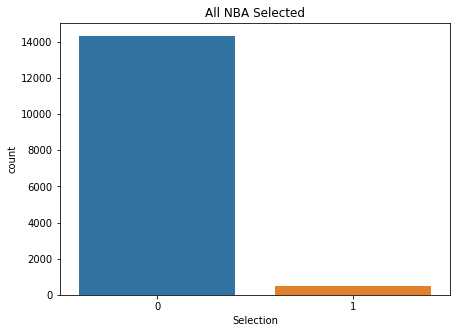

In [95]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='all_nba', data=all_nba_df)
_ = plt.title('All NBA Selected')
_ = plt.xlabel('Selection')

- Our dataset es very imbalanced, about 96.7 % of our data refers to the non-selected players.

In [96]:
scaler = StandardScaler()

X_train.loc[:, (X_train.columns != 'team')] = scaler.fit_transform(X_train.loc[:, (X_train.columns != 'team')])


X_test.loc[:, (X_test.columns != 'team')] = scaler.transform(X_test.loc[:, (X_test.columns != 'team')])

In [97]:
logistic_regressor = LogisticRegression()

logistic_regressor.fit(X_train.loc[:, (X_train.columns != 'team')],y_train)

LogisticRegression()

- Let's Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [133]:
# #: Excluiding 'team' from datasets
print("")
print('Evaluation of the baseline classifier:')
print("")

y_predicted = logistic_regressor.predict(X_test.loc[:, (X_test.columns != 'team')])

# #: Accuracy

blm_accuracy = accuracy_score(y_test,y_predicted)
print(f'Accuracy: {round(blm_accuracy,3)}')

# #: Precision

blm_precision = precision_score(y_test,y_predicted)
print(f'Precision: {round(blm_precision,3)}')

# #: Recall -> The ability of the classifier to find all the POSITIVE samples. In other words, how well detects the True Positives.

blm_recall = recall_score(y_test,y_predicted)
print(f'Recall: {round(blm_recall,3)}')

# #: F1

blm_f1 = f1_score(y_test,y_predicted)
print(f'F1: {round(blm_f1,3)}')



Evaluation of the baseline classifier:

Accuracy: 0.984
Precision: 0.788
Recall: 0.669
F1: 0.724


### Classification

#### Feature engineering

One hot encode the Team feature

In [134]:
# Encode X_train in team column

X_train = pd.get_dummies(data=X_train, columns=['team'])

In [135]:
# Encode X_test in team column

X_test = pd.get_dummies(data=X_test,columns=['team'])

In [136]:
# Drop team_TOT 

X_train.drop(columns=['team_TOT'], inplace=True)
X_test.drop(columns=['team_TOT'], inplace=True)

#### Modeling

In [137]:
def search_best_hypers_logistic(tol: float, C: float, max_iter: int) -> dict:
  """
  Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. 
  
  F1 score based as eval metric, but report also precision and recall. 
  
  Save the best performing model to use.

  Parameters
  ---------------------
  tol: float
  C: float
  max_iter: int

  Returns
  ---------------------
  result_lr: dict

  """
  result_lr = {
    "hyperparameters": {"tol": None, "C": None, "max_iter": None}, 
    "f1_score": None
  }
  best_f1_score = 0
  for tol_iter in tol:

    print(f'Trying tol: {tol_iter}')

    for C_iter in C:

      print(f'With {tol_iter}, trying C: {C_iter}')

      for max_iter_1 in max_iter:

        print(f'With {tol_iter} and C: {C_iter}, trying {max_iter_1}')

        logistic_regressor = LogisticRegression(tol=tol_iter, C= C_iter, max_iter=max_iter_1)
        logistic_regressor.fit(X_train,y_train)
        y_predicted = logistic_regressor.predict(X_test)

        f1 = f1_score(y_test, y_predicted)
        best_lr_precision = precision_score(y_test,y_predicted)
        print(f'Precision: {round(best_lr_precision,3)}')

        best_lr_recall = recall_score(y_test,y_predicted)
        print(f'Recall: {round(best_lr_recall,3)}')

        print(f'With {tol_iter} and C: {C_iter}, trying {max_iter_1} \n  F1 LEARNED: {f1}')
        if best_f1_score < f1:
          best_f1_score = f1
          result_lr = {
          "hyperparameters": {"tol": tol_iter, "C": C_iter, "max_iter_1": max_iter_1}, 
          "f1_score": round(f1,2), "Precision Score" : round(best_lr_precision,3), "Recall": round(best_lr_recall,3)
        }

  return result_lr

In [138]:
tol = np.linspace(0.0001,1,num=50)
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
max_iter = [10**3, 10**4, 10**5, 10**6, 10**7, 10**8]


result_lr = search_best_hypers_logistic(tol, C, max_iter)

Trying tol: 0.0001
With 0.0001, trying C: 0.001
With 0.0001 and C: 0.001, trying 1000
Precision: 1.0
Recall: 0.022
With 0.0001 and C: 0.001, trying 1000 
  F1 LEARNED: 0.04225352112676056
With 0.0001 and C: 0.001, trying 10000
Precision: 1.0
Recall: 0.022
With 0.0001 and C: 0.001, trying 10000 
  F1 LEARNED: 0.04225352112676056
With 0.0001 and C: 0.001, trying 100000
Precision: 1.0
Recall: 0.022
With 0.0001 and C: 0.001, trying 100000 
  F1 LEARNED: 0.04225352112676056
With 0.0001 and C: 0.001, trying 1000000
Precision: 1.0
Recall: 0.022
With 0.0001 and C: 0.001, trying 1000000 
  F1 LEARNED: 0.04225352112676056
With 0.0001 and C: 0.001, trying 10000000
Precision: 1.0
Recall: 0.022
With 0.0001 and C: 0.001, trying 10000000 
  F1 LEARNED: 0.04225352112676056
With 0.0001 and C: 0.001, trying 100000000
Precision: 1.0
Recall: 0.022
With 0.0001 and C: 0.001, trying 100000000 
  F1 LEARNED: 0.04225352112676056
With 0.0001, trying C: 0.01
With 0.0001 and C: 0.01, trying 1000
Precision: 0.873


In [139]:
print(result_lr)

{'hyperparameters': {'tol': 0.0001, 'C': 1, 'max_iter_1': 1000}, 'f1_score': 0.75, 'Precision Score': 0.808, 'Recall': 0.698}


#### Evaluating on New Data

In [140]:
best_tol_lr= result_lr['hyperparameters']['tol']
best_C_lr = result_lr['hyperparameters']['C']
best_max_iter_lr = result_lr['hyperparameters']['max_iter_1']
best_f1_lr = result_lr['f1_score']

In [8]:
all_nba_2018_df = pd.read_csv('all_nba_2018_dataset.csv', index_col=0)
all_nba_2018_selections = pd.read_csv('all_nba_2018_selections.csv', index_col=0)

In [142]:
# #: Define columns to not use
columns_unused = ['season_id', 'player_id', 'player_season', 'player', 'season', 'season_start','team']

In [143]:
# Scale just numerical features

all_nba_2018_df.loc[:, ~all_nba_2018_df.columns.isin(columns_unused)] = scaler.transform(all_nba_2018_df.loc[:, ~all_nba_2018_df.columns.isin(columns_unused)])

In [144]:
# Pick 40 teams
teams_full = pd.DataFrame(all_nba_df.team.unique())

# Pick 30 teams
teams_2018 = pd.DataFrame(all_nba_2018_df['team'].unique()) 

# Merge to obtain full 40 teams 
intersection = pd.merge(teams_full, teams_2018, how='outer', indicator=True) 

# Pick the 10 extra teams
antijoin = intersection[~(intersection['_merge']=='both')].drop('_merge', axis=1) 

# Create a df with those extra teams
ten_teams_new = pd.DataFrame(antijoin,  columns=antijoin) 

# Fill empty rows with 0
ten_teams_new.fillna(0,inplace=True)

# Convert rows (names of teams) in columns
for column in ten_teams_new.columns: 
    all_nba_2018_df[column] = ten_teams_new[column] 

In [145]:
# Encode 40 teams, drop rows with Nan values and columns we don't need.

# Encode teams
all_nba_2018_df = pd.get_dummies(data=all_nba_2018_df, columns=['team']) 

# Drop team_TOT to best fit the model
all_nba_2018_df.drop(columns=['team_TOT'], inplace=True) 

# fill with 0 empty rows
all_nba_2018_df.fillna(0,inplace=True) 

# pick just what you need
all_nba_2018_df = all_nba_2018_df.loc[:, ~all_nba_2018_df.columns.isin(columns_unused)] 

Predict and evaluate the model using precision, recall and f1 score. 

In [147]:
# Predict with the best regressor

best_lr = LogisticRegression(tol= 0.0001, C= 1, max_iter= 1000)
best_lr.fit(X_train,y_train)
y_predicted = best_lr.predict(all_nba_2018_df)

c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [148]:
# #: Precision
print("")
precision_new = precision_score(all_nba_2018_selections.all_nba,y_predicted)
print(f'Precision: {round(precision_new,3)}')
print("")

# #: Recall -> The ability of the classifier to find all the POSITIVE samples. In other words, how well detects the True Positives.

recall_new = recall_score(all_nba_2018_selections.all_nba,y_predicted)
print(f'Recall: {round(recall_new,3)}')
print("")

# #: F1

f1_new = f1_score(all_nba_2018_selections.all_nba,y_predicted)
print(f'F1: {round(f1_new,3)}')
print("")


Precision: 0.625

Recall: 1.0

F1: 0.769



- Our dataset is imbalanced and the positive class (selected by all_nba) is the minority class. There are a lot of negative examples that could be converted into False Positives.

#### Creating a custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

In [149]:
# Make predictions for our dataset
selection = best_lr.predict(all_nba_2018_df) 

# create the y_true (ground of truth)
y_true = all_nba_2018_selections['all_nba'] 

# Let's see how well my predicton works
print('F1: ', round(f1_score(y_true , selection),3)) 

# calculate the probability of being selected 
array_probs = best_lr.predict_proba(X=all_nba_2018_df)

nba_full = all_nba_2018_selections.copy()

print('Dataframe of probabilities to be chosen for ALL NBA')

# with the calculated probability, picked the one who refers to the posibility of being selected
nba_full['PROBABILITY_OF_BEING_SELECTED'] = list(array_probs[:, 1])

# make a list with every position oredered and add it to the df
nba_full['PREDICTIONS'] = list(selection) 
nba_full['PROBABILITY_OF_BEING_SELECTED'] = round(nba_full['PROBABILITY_OF_BEING_SELECTED'],3) 
nba_full.sort_values(by=['PROBABILITY_OF_BEING_SELECTED'], ascending=False) 
print("")
display(nba_full.loc[:,['player_id', 'player','PROBABILITY_OF_BEING_SELECTED']])



F1:  0.769
Dataframe of probabilities to be chosen for ALL NBA



c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,player_id,player,PROBABILITY_OF_BEING_SELECTED
34,5,Alex Abrines,0.000
49,8,Quincy Acy,0.000
70,10,Jaylen Adams,0.000
71,13,Steven Adams,0.052
79,15,Bam Adebayo,0.000
...,...,...,...
15319,2806,Trae Young,0.381
15333,2808,Cody Zeller,0.001
15334,2810,Tyler Zeller,0.000
15350,2818,Ante Zizic,0.000


Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [150]:
nba_full.sort_values(by=['PROBABILITY_OF_BEING_SELECTED'], ascending=False)[0:15]

,player_id,player,all_nba,PROBABILITY_OF_BEING_SELECTED,PREDICTIONS
453,83,Giannis Antetokounmpo,1,0.999,1
5604,1024,James Harden,1,0.995,1
3401,587,Anthony Davis,0,0.994,1
6857,1240,LeBron James,1,0.991,1
4145,740,Joel Embiid,1,0.991,1
3908,695,Kevin Durant,1,0.983,1
14027,2572,Nikola Vucevic,0,0.972,1
8206,1511,Damian Lillard,1,0.941,1
14479,2648,Russell Westbrook,1,0.929,1
13673,2501,Karl-Anthony Towns,0,0.920,1


- Players actually selected from the all_nba_2018_selections dataset,
- Players actually selected missing from OUR predictions+
- Players in our predictions not selected 

In [151]:
print("")
print('Players actually selected from the all_nba_2018_selections dataset: ')
display(nba_full[nba_full['all_nba'] == 1])
print("")
print('Players actually selected missing from OUR predictions: ')
display(nba_full[(nba_full['all_nba'] == 1) & (nba_full['PREDICTIONS'] == 0)])
print("")
print('Players in our predictions not selected: ' )
display(nba_full[(nba_full['all_nba'] == 0) & (nba_full['PREDICTIONS'] == 1)])



Players actually selected from the all_nba_2018_selections dataset: 


,player_id,player,all_nba,PROBABILITY_OF_BEING_SELECTED,PREDICTIONS
453,83,Giannis Antetokounmpo,1,0.999,1
3168,570,Stephen Curry,1,0.901,1
3908,695,Kevin Durant,1,0.983,1
4145,740,Joel Embiid,1,0.991,1
4895,884,Paul George,1,0.846,1
5016,909,Rudy Gobert,1,0.822,1
5399,979,Blake Griffin,1,0.665,1
5604,1024,James Harden,1,0.995,1
6634,1204,Kyrie Irving,1,0.865,1
6857,1240,LeBron James,1,0.991,1



Players actually selected missing from OUR predictions: 


,player_id,player,all_nba,PROBABILITY_OF_BEING_SELECTED,PREDICTIONS



Players in our predictions not selected: 


,player_id,player,all_nba,PROBABILITY_OF_BEING_SELECTED,PREDICTIONS
168,30,LaMarcus Aldridge,0,0.676,1
1048,179,Bradley Beal,0,0.583,1
3401,587,Anthony Davis,0,0.994,1
3538,633,DeMar DeRozan,0,0.540,1
3794,682,Andre Drummond,0,0.723,1
6218,1131,Jrue Holiday,0,0.615,1
12473,2267,Ben Simmons,0,0.877,1
13673,2501,Karl-Anthony Towns,0,0.920,1
14027,2572,Nikola Vucevic,0,0.972,1


Class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [152]:
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor
    
    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    self.model = model

  def predict(self,X: pd.DataFrame) -> np.ndarray:
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15
    
    Parameters
    ----------
    X: pd.DataFrame
      a dataframe with the players data
        
    Returns
    -------
    np.ndarray
      # An array of the same length as # y, with 15 true results based on the players with most probabilities of
      beign selected
    """
    # Predictions of my model
    selections = self.model.predict(X)
    probabilities = self.model.predict_proba(X)

    # Round, sort and pick the first 15 better probabilities to be selected
    probabilities = np.round(probabilities,3)
    probabilities = probabilities[:,1]

    # Copy df then convert probs & selections from arrays to columns
    nba_best_15 = X.copy()
    nba_best_15['PROBABILITY_OF_BEING_SELECTED'] = probabilities
    nba_best_15['PREDICTIONS'] = selections

    # sort values & put 0 to the best 1 - p probabilities of not being selected
    nba_best_15 = nba_best_15.sort_values(by='PROBABILITY_OF_BEING_SELECTED',ascending=False)
    nba_best_15.loc[nba_best_15.index[15:], 'PREDICTIONS'] = 0

    # sort index
    nba_best_15.sort_index(axis=0, inplace=True)

    # create sorted array
    nba_best_15_final = nba_best_15.loc[:, 'PREDICTIONS']

    return nba_best_15_final
  

Let's use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [153]:
# Create the classifier
nba_classifier = AllNbaSingleSeasonClassifier(best_lr)
y_pred = nba_classifier.predict(all_nba_2018_df)


# #: Precision
print("")
precision_my_classifier = precision_score(all_nba_2018_selections.all_nba,y_pred)
print(f'Precision: {round(precision_my_classifier,3)}')
print("")
# #: Recall -> The ability of the classifier to find all the POSITIVE samples. In other words, how well detects the True Positives.

recall_my_classifier = recall_score(all_nba_2018_selections.all_nba,y_pred)
print(f'Recall: {round(recall_my_classifier,3)}')
print("")
# #: F1

f1_my_classifier = f1_score(all_nba_2018_selections.all_nba,y_pred)
print(f'F1: {round(f1_my_classifier,3)}')
print("")


Precision: 0.733

Recall: 0.733

F1: 0.733



c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Fede\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Analyzing our results

- The main problem it's the imbalaced dataset, the oversampled negative class skewed our model. Barely the 3% of our samples are from the selected ones(positive class). Our model is being biased by the negative class.

What can we do to improve our model?

1. Resampling: undersampling or oversampling and re-training our model
2. Implement SMOTE to treat imbalanced datasets